In [1]:
# install
# pip install novosparc
# imports
from importlib import reload

import anndata
%matplotlib inline
import novosparc
import os
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
# import altair as alt
from scipy.spatial.distance import cdist, squareform, pdist
from scipy.stats import ks_2samp
from scipy.stats import pearsonr

import random
random.seed(0)

# test genes
pl_genes = ['sna', 'ken', 'eve','zen2','ush','ImpE2','Adgf-A']

# Reading expression data to scanpy AnnData (cells x genes)
data_dir = 'novosparc/datasets/drosophila_scRNAseq/'
data_path = os.path.join(data_dir, 'dge_normalized.txt')
dataset = sc.read(data_path).T
gene_names = dataset.var.index.tolist()

num_cells, num_genes = dataset.shape # 1297 cells x 8924 genes

print('number of cells: %d' % num_cells)
print('number of genes: %d' % num_genes)
# optional: subset cells
num_cells = 1000
sc.pp.subsample(dataset, n_obs=num_cells)
dge_rep = None # a representation of cells gene expression
sc.pp.highly_variable_genes(dataset)
is_var_gene = dataset.var['highly_variable']
var_genes = list(is_var_gene.index[is_var_gene])

# alternative 1: variable expressed genes representation
# dge_rep = dataset.to_df()[var_genes]

# alternative 2: pca representation
sc.pp.pca(dataset)
# dge_rep = pd.DataFrame(dataset.obsm['X_pca'])
atlas_dir = 'novosparc/datasets/bdtnp/'
target_space_path = os.path.join(atlas_dir, 'geometry.txt')
locations = pd.read_csv(target_space_path, sep=' ')
num_locations = 3039
locations_apriori = locations[:num_locations][['xcoord', 'zcoord']].values

number of cells: 1297
number of genes: 8924


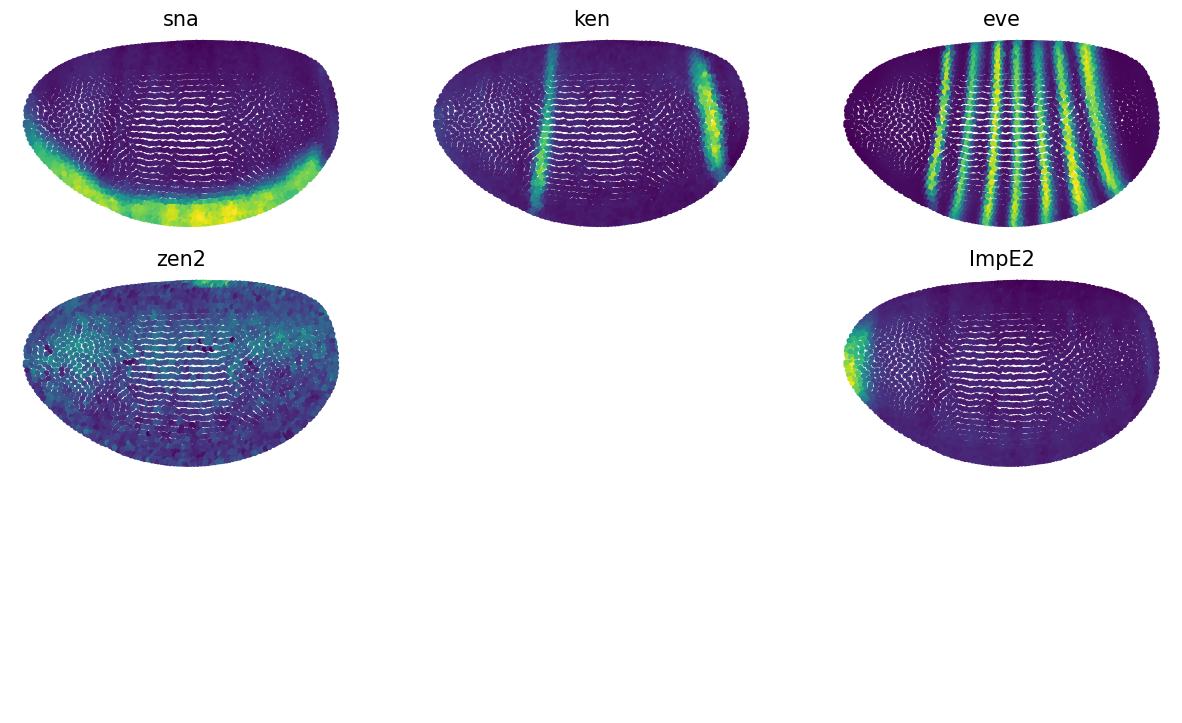

<Figure size 432x288 with 0 Axes>

In [2]:
# reading reference atlas
locations = locations_apriori
atlas_dir = 'novosparc/datasets/bdtnp/'
atlas_path = os.path.join(atlas_dir, 'dge.txt')
atlas = sc.read(atlas_path)
atlas_genes = atlas.var.index.tolist()
atlas.obsm['spatial'] = locations

novosparc.pl.embedding(atlas, pl_genes)

# calculate cost matrix
# params for smooth cost
num_neighbors_s = num_neighbors_t = 5

# params for linear cost
markers = list(set(atlas_genes).intersection(gene_names))
atlas_matrix = atlas.to_df()[markers].values
markers_idx = pd.DataFrame({'markers_idx': np.arange(num_genes)}, index=gene_names)
markers_to_use = np.concatenate(markers_idx.loc[markers].values)

## Normal reconstruction

Setting up for reconstruction ... done ( 3.8 seconds )
Setting up for reconstruction ... done ( 3.96 seconds )
Reconstructing spatial information with 84 markers: 1000 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03
Trying with epsilon: 5.00e-03


/tmp/ipykernel_13257/1488039006.py:21: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


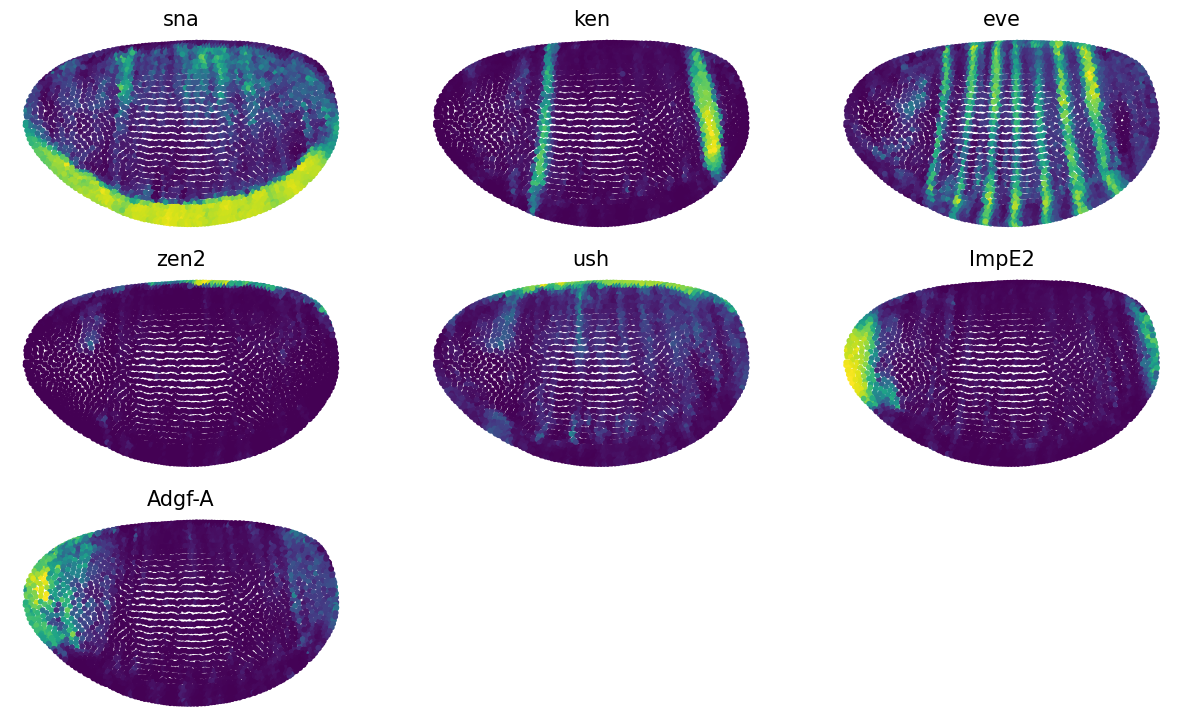

<Figure size 432x288 with 0 Axes>

In [3]:
# construct tissue object
tissue = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)


tissue.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

# dge_rep = None
tissue.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

# reconstructed expression of individual genes
sdge = tissue.sdge
dataset_reconst = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst.obsm['spatial'] = locations_apriori

novosparc.pl.embedding(dataset_reconst, pl_genes)

## Cleaning before reconstruction

! here I'm not sure how changing the tissue.dge interacts with the dge_rep?
In the outputs you can see that the dge is successfully altered. But since there is no change at all in the reconstruction, I'm not quite sure yet if this change is used as expected in the reconstruction


In [4]:
# construct tissue object
tissue_precleaned = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)

In [5]:
tissue_precleaned.dge.T

array([[0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 3.808, ..., 2.961, 0.   , 0.   ],
       [8.924, 8.878, 8.704, ..., 8.126, 8.152, 8.657],
       ...,
       [2.296, 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , ..., 0.   , 0.   , 0.   ],
       [3.67 , 3.949, 5.067, ..., 5.127, 4.922, 3.436]], dtype=float32)

In [6]:
%%time
tissue_precleaned.cleaning_expression_data(dataset,expression_matrix=tissue_precleaned.dge.T,normalization='zscore', selected_genes=pl_genes, cov_prior=[(400,)])

CPU times: user 1.34 s, sys: 594 ms, total: 1.94 s
Wall time: 1.05 s


In [7]:
tissue_precleaned.cleaned_dge

array([[0.        , 0.        , 8.92399979, ..., 2.296     , 0.        ,
        3.67000008],
       [0.        , 0.        , 8.87800026, ..., 0.        , 0.        ,
        3.94899988],
       [0.        , 3.80800009, 8.70400047, ..., 0.        , 0.        ,
        5.06699991],
       ...,
       [0.        , 2.96099997, 8.1260004 , ..., 0.        , 0.        ,
        5.12699986],
       [0.        , 0.        , 8.15200043, ..., 0.        , 0.        ,
        4.92199993],
       [0.        , 0.        , 8.65699959, ..., 0.        , 0.        ,
        3.43600011]])

In [8]:
# take the cleaned_dge as dge
tissue_precleaned.dge = tissue_precleaned.cleaned_dge

In [9]:
# alternative 1: setup both assumptions
tissue_precleaned.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

tissue_precleaned.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

Setting up for reconstruction ... done ( 3.71 seconds )
Setting up for reconstruction ... done ( 3.61 seconds )


In [10]:
# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue_precleaned.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

Reconstructing spatial information with 84 markers: 1000 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03
Trying with epsilon: 5.00e-03


/tmp/ipykernel_13257/1960691772.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst_precleaned = sc.AnnData(pd.DataFrame(sdge_precleaned.T, columns=gene_names))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


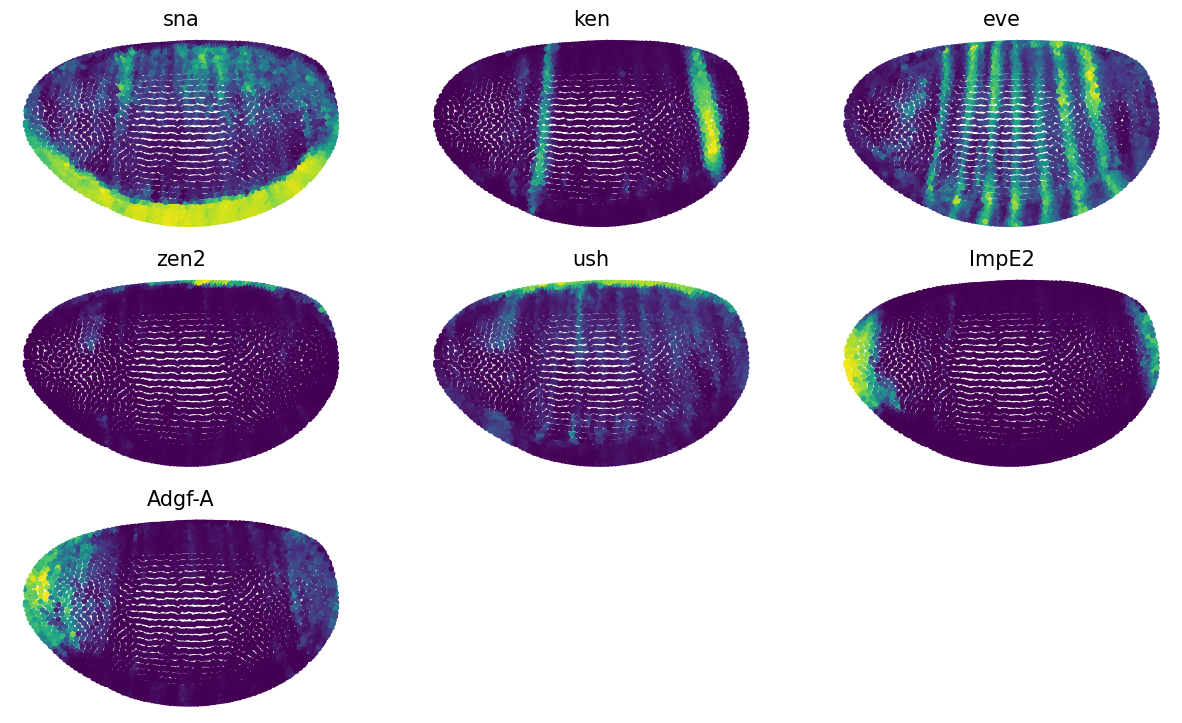

<Figure size 432x288 with 0 Axes>

In [11]:
# reconstructed expression of individual genes
sdge_precleaned = tissue_precleaned.sdge
dataset_reconst_precleaned = sc.AnnData(pd.DataFrame(sdge_precleaned.T, columns=gene_names))
dataset_reconst_precleaned.obsm['spatial'] = locations_apriori

novosparc.pl.embedding(dataset_reconst_precleaned, pl_genes)

## Cleaning after reconstruction

In [12]:
# construct tissue object
tissue_postcleaned = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)

# alternative 1: setup both assumptions
tissue_postcleaned.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

tissue_postcleaned.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue_postcleaned.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

# reconstructed expression of individual genes
sdge = tissue_postcleaned.sdge
dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst_postcleaned.obsm['spatial'] = locations_apriori

Setting up for reconstruction ... done ( 3.72 seconds )
Setting up for reconstruction ... done ( 3.76 seconds )
Reconstructing spatial information with 84 markers: 1000 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03
Trying with epsilon: 5.00e-03


/tmp/ipykernel_13257/2127896571.py:20: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [13]:
%%time
tissue_postcleaned.cleaning_expression_data(dataset_reconst_postcleaned,tissue_postcleaned.sdge.T,normalization='zscore',    selected_genes=pl_genes, cov_prior=[(400,)])

CPU times: user 1.57 s, sys: 441 ms, total: 2.01 s
Wall time: 1.39 s


/tmp/ipykernel_13257/532681064.py:3: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge_postcleaned, columns=gene_names))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


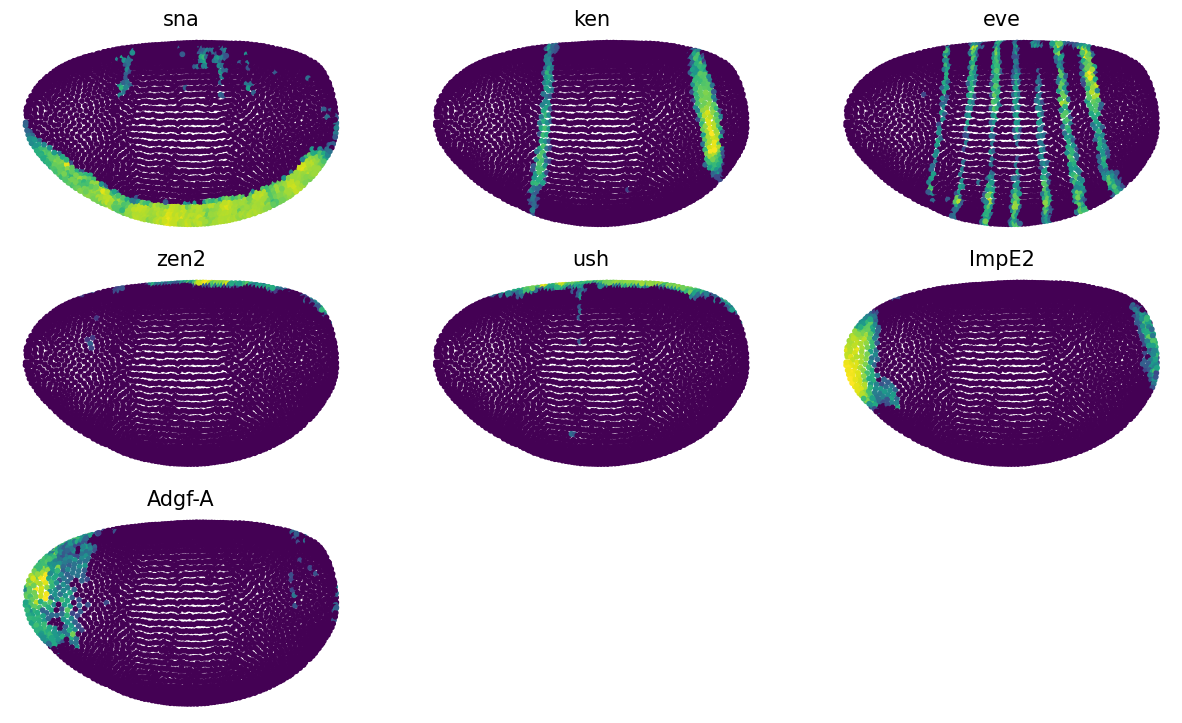

<Figure size 432x288 with 0 Axes>

In [14]:
# reconstructed expression of individual genes
sdge_postcleaned = tissue_postcleaned.cleaned_dge
dataset_reconst_postcleaned = sc.AnnData(pd.DataFrame(sdge_postcleaned, columns=gene_names))
dataset_reconst_postcleaned.obsm['spatial'] = locations_apriori

novosparc.pl.embedding(dataset_reconst_postcleaned, pl_genes)

## Filtering pre + post reconstruction

Setting up for reconstruction ... done ( 3.87 seconds )
Setting up for reconstruction ... done ( 3.83 seconds )
Reconstructing spatial information with 84 markers: 1000 cells and 3039 locations ... 
Trying with epsilon: 5.00e-03
Trying with epsilon: 5.00e-03


/tmp/ipykernel_13257/3695665210.py:24: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst_prepostcleaned_1 = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
/home/vfs/anaconda3/envs/rajewskyLab/lib/python3.9/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/tmp/ipykernel_13257/3695665210.py:31: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  dataset_reconst_postcleaned_2 = sc.AnnData(pd.DataFrame(sdge_postcleaned, columns=gene_names))
/home/vfs/a

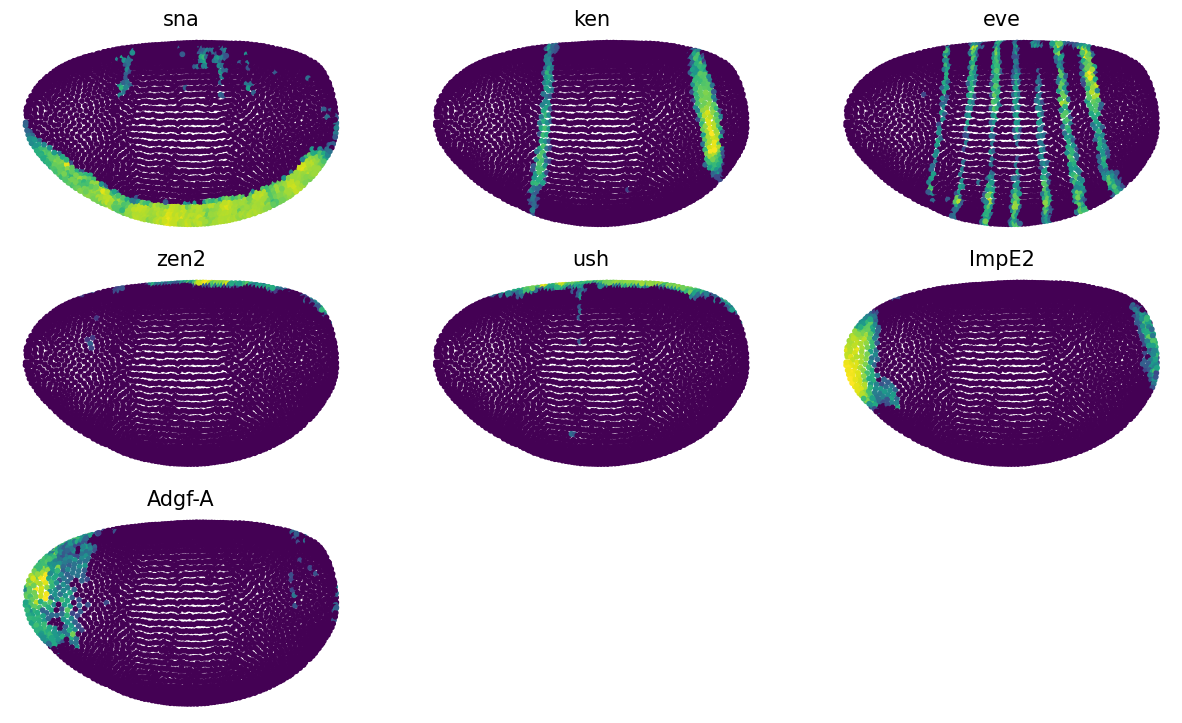

<Figure size 432x288 with 0 Axes>

In [17]:
# construct tissue object
tissue_prepostcleaned = novosparc.cm.Tissue(dataset=dataset, locations=locations_apriori)

tissue_prepostcleaned.cleaning_expression_data(dataset,expression_matrix=tissue_prepostcleaned.dge.T,normalization='zscore', selected_genes=pl_genes, cov_prior=[(400,)])

# take the cleaned_dge as dge
tissue_prepostcleaned.dge = tissue_prepostcleaned.cleaned_dge

tissue_prepostcleaned.setup_reconstruction(atlas_matrix=atlas_matrix,
                            markers_to_use=markers_to_use,
                            num_neighbors_s=num_neighbors_s,
                            num_neighbors_t=num_neighbors_t)

tissue_prepostcleaned.setup_smooth_costs(dge_rep=dge_rep, num_neighbors_s=num_neighbors_s, num_neighbors_t=num_neighbors_t)

# compute optimal transport of cells to locations
alpha_linear = 0.8
epsilon = 5e-3
# tissue.dge = sparse.csr_matrix(tissue.dge)
tissue_prepostcleaned.reconstruct(alpha_linear=alpha_linear, epsilon=epsilon)

# reconstructed expression of individual genes
sdge = tissue_prepostcleaned.sdge
dataset_reconst_prepostcleaned_1 = sc.AnnData(pd.DataFrame(sdge.T, columns=gene_names))
dataset_reconst_prepostcleaned_1.obsm['spatial'] = locations_apriori

tissue_postcleaned.cleaning_expression_data(dataset_reconst_prepostcleaned_1,tissue_prepostcleaned.sdge.T,normalization='zscore',    selected_genes=pl_genes, cov_prior=[(400,)])

# reconstructed expression of individual genes
sdge_prepostcleaned = tissue_postcleaned.cleaned_dge
dataset_reconst_postcleaned_2 = sc.AnnData(pd.DataFrame(sdge_postcleaned, columns=gene_names))
dataset_reconst_postcleaned_2.obsm['spatial'] = locations_apriori

novosparc.pl.embedding(dataset_reconst_postcleaned_2, pl_genes)